In [56]:
from statsmodels.api import OLS
from statsmodels.stats.outliers_influence import OLSInfluence
from sklearn.metrics import mean_squared_error
from sklearn import linear_model, tree, neighbors, model_selection
from patsy import dmatrices
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def split(X, y):
    return model_selection.train_test_split(X, y, test_size=.25, random_state=42)

def remove_high_lever_outliers(y, X, param_lever, result):
    leverage = pd.Series(OLSInfluence(result).influence, name = "leverage")
    return y[ np.array(leverage < param_lever) ], X[ np.array(leverage < param_lever) ]

def prepare_data(dataset, formula):
    y, X = dmatrices(formula, data=dataset, return_type='dataframe')
    return (*(split(X, y)), formula)

def analyze_model(X_train, X_valid, y_train, y_valid, formula):
    result = OLS(y_train, X_train).fit()
    print(formula, "   MSE=", mean_squared_error(y_valid, result.predict(X_valid)))
    return result

def removed_influence(dataset, formula, influence_cut_param):
    X_train, X_valid, y_train, y_valid, _ = prepare_data(dataset, formula)
    print('--------------------------')
    print("Before influence removal:")
    result = analyze_model(X_train, X_valid, y_train, y_valid, formula)
    y_train, X_train = remove_high_lever_outliers(y_train, X_train, influence_cut_param, result)
    print("After influence removal:")
    analyze_model(X_train, X_valid, y_train, y_valid, formula)
    print('--------------------------')


mpg ~ horsepower    MSE= 21.909181244268424
acceleration ~ horsepower    MSE= 3.2817144145987722
mpg ~ np.log(horsepower)*np.log(cylinders)*displacement*np.log(acceleration)*np.log(weight)*year    MSE= 7.254857354707228
--------------------------
Before influence removal:
mpg ~ horsepower    MSE= 21.909181244268424
After influence removal:
mpg ~ horsepower    MSE= 22.858173240159132
--------------------------
mpg ~ year    MSE= 36.21516831394257
mpg ~ C(year)    MSE= 34.30693242444662


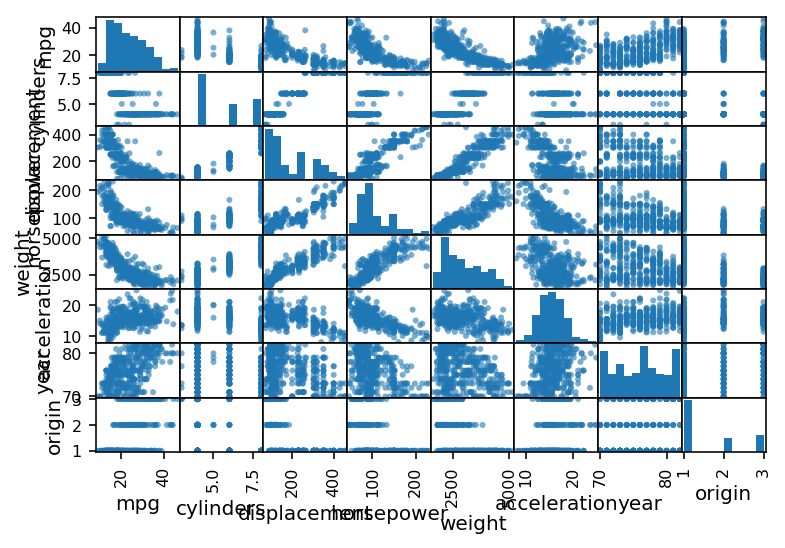

In [55]:
%config InlineBackend.figure_format = 'retina'
dataset_auto = pd.read_csv('database/Auto.csv', na_values=['?']).dropna()
pd.plotting.scatter_matrix(dataset_auto, alpha=0.6)
analyze_model(*prepare_data(dataset_auto, 'mpg ~ horsepower'))
analyze_model(*prepare_data(dataset_auto, 'acceleration ~ horsepower'))

analyze_model(*prepare_data(dataset_auto, 
                'mpg ~ np.log(horsepower)*np.log(cylinders)*displacement*np.log(acceleration)*np.log(weight)*year'))

removed_influence(dataset_auto, 'mpg ~ horsepower', 0.15)
analyze_model(*prepare_data(dataset_auto, 'mpg ~ year'))
analyze_model(*prepare_data(dataset_auto, 'mpg ~ C(year)'))
